# Creation of a neural network with Keras for the classification of products from the data set fashion_mnist.

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras.datasets import fashion_mnist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

%matplotlib inline

import os
# macOS specipic workaround for not working GPU on tf v2.16.1
# os.environ['TF_USE_LEGACY_KERAS'] = '1'
# When = 3, the messages (1 - informational(I), 2 - warnings(W) and 3- errors(E)) will not be logged during code execution.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
print("TensorFlow", tf.__version__)
# Ensure we see the GPU in device list in the macOS.
# print('Visible Devices: ', tf.config.get_visible_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


TensorFlow 2.15.0


## Load data

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
# data preprocessing
X_train = X_train.reshape(X_train.shape[0], 28 * 28) / 255
X_test = X_test.reshape(X_test.shape[0], 28 * 28) / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Model v1

In [ ]:
model_v1 = Sequential(name='v1')
model_v1.add(Dense(64, activation='relu', input_shape=(784, ), name='v1_hidden1'))
model_v1.add(Dense(10, activation='sigmoid', name='v1_output'))

model_v1.compile(
    optimizer='SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_v1.summary()

Model: "v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v1_hidden1 (Dense)          (None, 64)                50240     
                                                                 
 v1_output (Dense)           (None, 10)                650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 50890 (198.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
history_model_v1=model_v1.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.2,
    # verbose=1,
)

Epoch 1/25
750/750 [==============================] - 6s 7ms/step - loss: 0.9778 - accuracy: 0.6955 - val_loss: 0.6846 - val_accuracy: 0.7763
Epoch 2/25
750/750 [==============================] - 3s 3ms/step - loss: 0.6244 - accuracy: 0.7937 - val_loss: 0.5802 - val_accuracy: 0.8047
Epoch 3/25
750/750 [==============================] - 2s 3ms/step - loss: 0.5526 - accuracy: 0.8165 - val_loss: 0.5338 - val_accuracy: 0.8188
Epoch 4/25
750/750 [==============================] - 2s 2ms/step - loss: 0.5146 - accuracy: 0.8265 - val_loss: 0.5045 - val_accuracy: 0.8261
Epoch 5/25
750/750 [==============================] - 2s 3ms/step - loss: 0.4911 - accuracy: 0.8348 - val_loss: 0.4858 - val_accuracy: 0.8333
Epoch 6/25
750/750 [==============================] - 2s 3ms/step - loss: 0.4741 - accuracy: 0.8382 - val_loss: 0.4793 - val_accuracy: 0.8320
Epoch 7/25
750/750 [==============================] - 2s 3ms/step - loss: 0.4609 - accuracy: 0.8421 - val_loss: 0.4674 - val_accuracy: 0.8363
Epoch 

In [ ]:
def plot_model(history=None, model_version='v1'):
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', marker='x')
    plt.plot(history.history['loss'], label='Training Loss', color='red', linestyle='--')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='goldenrod', linestyle='--', marker='x')
    plt.title(f'Model {model_version} - Training and Validation Performance', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy and Loss (Scored Separately)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

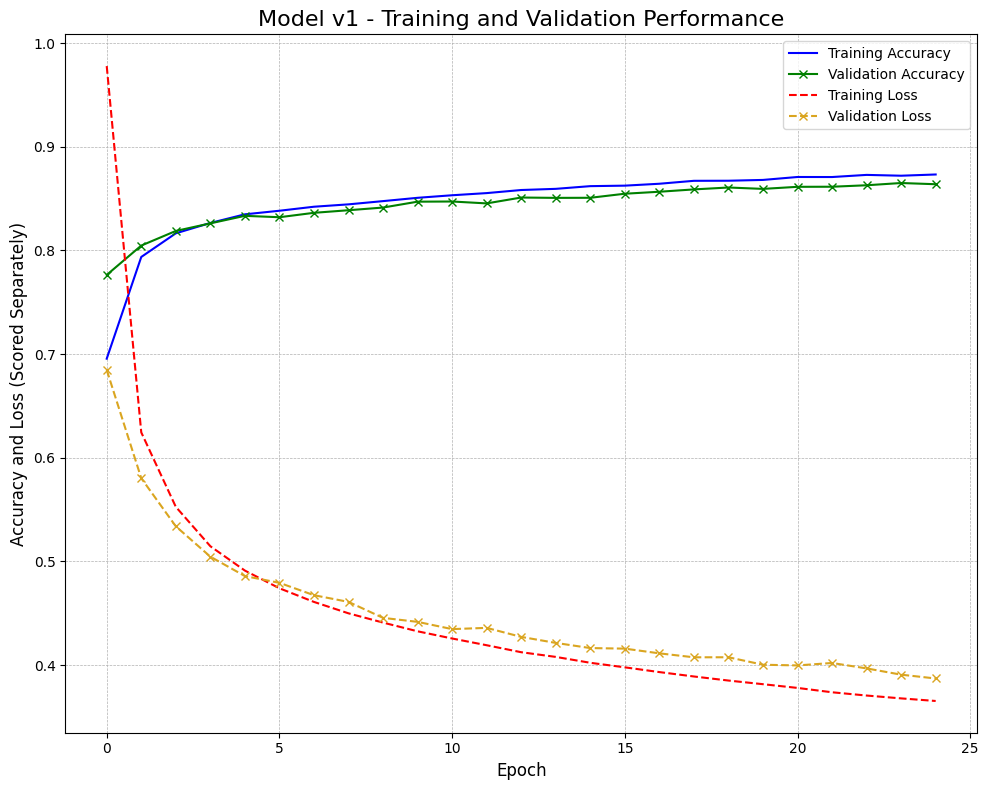

In [ ]:
plot_model(history_model_v1, model_version='v1')

In [ ]:
loss_model_v1, accuracy_model_v1 = model_v1.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   ')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}')


313/313 [==============================] - 2s 5ms/step - loss: 0.4084 - accuracy: 0.8547
  Model    Loss   Accuracy   
    v1   0.4084     0.8547


### Model v1 Summary


* Accuracy falls below the minimum acceptable threshold of 0.91.
* Further investigation or model improvements might be necessary.


## Model v2

In [ ]:
model_v2 = Sequential(name='v2')
model_v2.add(Dense(128, activation='relu', input_shape=(784,), name='v2_hidden1')) # changed 64 -> 128
model_v2.add(Dense(10, activation='sigmoid', name='v2_output'))

model_v2.compile(
    optimizer='SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_v2.summary()

Model: "v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v2_hidden1 (Dense)          (None, 128)               100480    
                                                                 
 v2_output (Dense)           (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
history_model_v2=model_v2.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.2,
    # verbose=1,
)

Epoch 1/25
750/750 [==============================] - 5s 5ms/step - loss: 0.9494 - accuracy: 0.7133 - val_loss: 0.6510 - val_accuracy: 0.7920
Epoch 2/25
750/750 [==============================] - 2s 3ms/step - loss: 0.6040 - accuracy: 0.8038 - val_loss: 0.5575 - val_accuracy: 0.8169
Epoch 3/25
750/750 [==============================] - 3s 4ms/step - loss: 0.5390 - accuracy: 0.8201 - val_loss: 0.5205 - val_accuracy: 0.8231
Epoch 4/25
750/750 [==============================] - 2s 3ms/step - loss: 0.5046 - accuracy: 0.8277 - val_loss: 0.4942 - val_accuracy: 0.8296
Epoch 5/25
750/750 [==============================] - 2s 3ms/step - loss: 0.4828 - accuracy: 0.8356 - val_loss: 0.4852 - val_accuracy: 0.8306
Epoch 6/25
750/750 [==============================] - 2s 3ms/step - loss: 0.4663 - accuracy: 0.8408 - val_loss: 0.4644 - val_accuracy: 0.8372
Epoch 7/25
750/750 [==============================] - 3s 4ms/step - loss: 0.4533 - accuracy: 0.8443 - val_loss: 0.4526 - val_accuracy: 0.8418
Epoch 

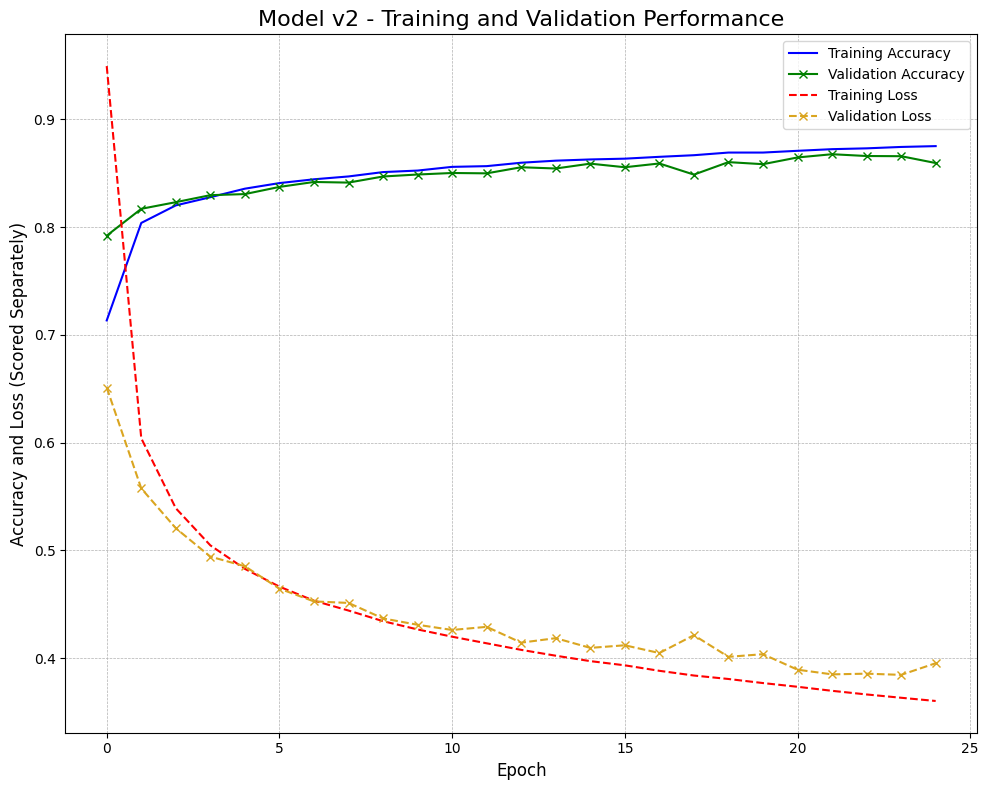

In [ ]:
plot_model(history_model_v2, model_version='v2')

In [ ]:
loss_model_v2, accuracy_model_v2 = model_v2.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   ')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}  # changed number of neurons in the first layer 64 -> 128')

313/313 [==============================] - 1s 2ms/step - loss: 0.4205 - accuracy: 0.8522
  Model    Loss   Accuracy   
    v1   0.4084     0.8547
    v2   0.4205     0.8522  # changed number of neurons in the first layer 64 -> 128


### Model v2 Summary


* Accuracy falls below the minimum acceptable threshold of 0.91.
* Achieved higher or the same test accuracy and loss compared to Model v1.
* Further investigation or model improvements might still be necessary.


## Model v3

In [ ]:
model_v3 = Sequential(name='v3')
model_v3.add(Dense(128, activation='relu', input_shape=(784,), name='v3_hidden1'))
model_v3.add(Dropout(0.2, name='v3_hidden2')) # changed: added new layer
model_v3.add(Dense(10, activation='sigmoid', name='v3_output'))

model_v3.compile(
    optimizer='SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_v3.summary()

Model: "v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v3_hidden1 (Dense)          (None, 128)               100480    
                                                                 
 v3_hidden2 (Dropout)        (None, 128)               0         
                                                                 
 v3_output (Dense)           (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
history_model_v3=model_v3.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.2,
    # verbose=1,
)

Epoch 1/25
750/750 [==============================] - 4s 4ms/step - loss: 1.0370 - accuracy: 0.6602 - val_loss: 0.7008 - val_accuracy: 0.7613
Epoch 2/25
750/750 [==============================] - 3s 4ms/step - loss: 0.6915 - accuracy: 0.7655 - val_loss: 0.5899 - val_accuracy: 0.8037
Epoch 3/25
750/750 [==============================] - 2s 3ms/step - loss: 0.6084 - accuracy: 0.7962 - val_loss: 0.5406 - val_accuracy: 0.8178
Epoch 4/25
750/750 [==============================] - 2s 3ms/step - loss: 0.5624 - accuracy: 0.8099 - val_loss: 0.5097 - val_accuracy: 0.8284
Epoch 5/25
750/750 [==============================] - 2s 3ms/step - loss: 0.5302 - accuracy: 0.8184 - val_loss: 0.4963 - val_accuracy: 0.8275
Epoch 6/25
750/750 [==============================] - 3s 4ms/step - loss: 0.5075 - accuracy: 0.8266 - val_loss: 0.4789 - val_accuracy: 0.8354
Epoch 7/25
750/750 [==============================] - 3s 4ms/step - loss: 0.4907 - accuracy: 0.8328 - val_loss: 0.4595 - val_accuracy: 0.8405
Epoch 

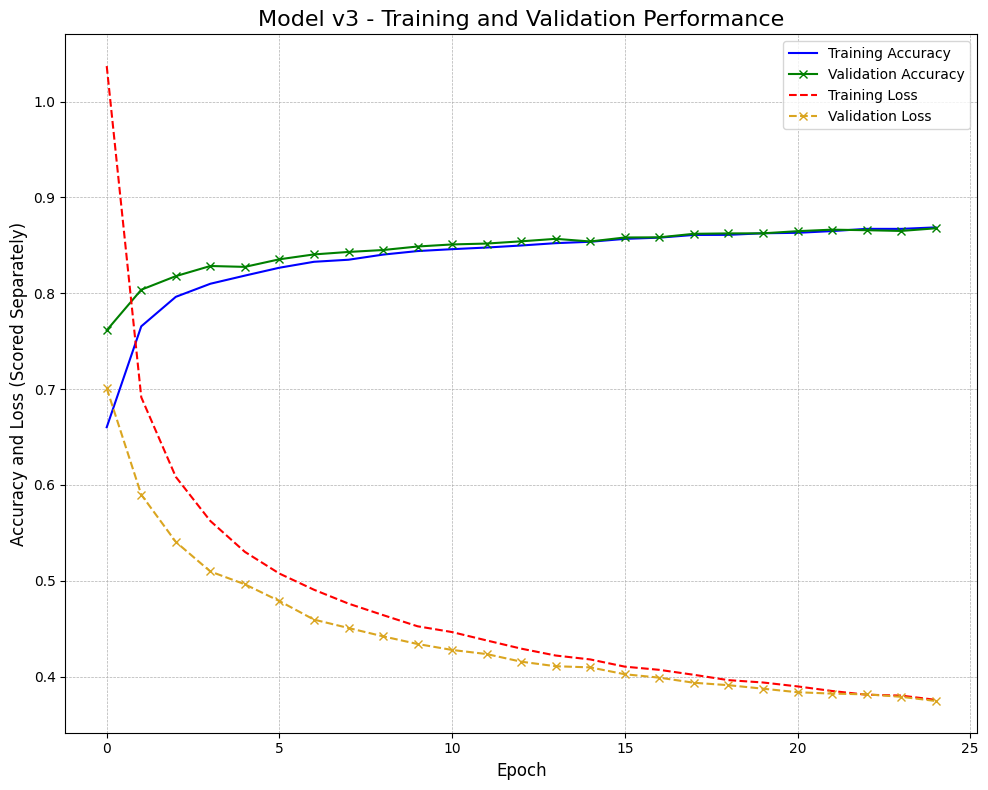

In [ ]:
plot_model(history_model_v3, model_version='v3')

In [ ]:
loss_model_v3, accuracy_model_v3 = model_v3.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')

313/313 [==============================] - 1s 3ms/step - loss: 0.3976 - accuracy: 0.8598
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)


### Model v3 Summary

* Added a Dropout layer with a rate of 0.2 to help prevent overfitting.
* Accuracy falls below the minimum acceptable threshold of 0.91.
* Achieved the highest test accuracy and lowest loss among v1, v2 and v3.
* Further investigation or model improvements might still be necessary.

## Model v4

In [ ]:
model_v4 = Sequential(name='v4')
model_v4.add(Dense(128, activation='relu', input_shape=(784,), name='v4_hidden1'))
model_v4.add(Dropout(0.2, name='v4_hidden2'))
model_v4.add(Dense(10, activation='sigmoid', name='v4_output'))

model_v4.compile(
    optimizer='Adam', # changed optimiser from SGD to Adam
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_v4.summary()

Model: "v4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v4_hidden1 (Dense)          (None, 128)               100480    
                                                                 
 v4_hidden2 (Dropout)        (None, 128)               0         
                                                                 
 v4_output (Dense)           (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
history_model_v4=model_v4.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.2,
    # verbose=1,
)

Epoch 1/25
750/750 [==============================] - 4s 4ms/step - loss: 0.5869 - accuracy: 0.7966 - val_loss: 0.4255 - val_accuracy: 0.8507
Epoch 2/25
750/750 [==============================] - 3s 4ms/step - loss: 0.4263 - accuracy: 0.8487 - val_loss: 0.3910 - val_accuracy: 0.8575
Epoch 3/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3817 - accuracy: 0.8616 - val_loss: 0.3771 - val_accuracy: 0.8617
Epoch 4/25
750/750 [==============================] - 4s 5ms/step - loss: 0.3558 - accuracy: 0.8704 - val_loss: 0.3453 - val_accuracy: 0.8757
Epoch 5/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3397 - accuracy: 0.8763 - val_loss: 0.3407 - val_accuracy: 0.8781
Epoch 6/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3249 - accuracy: 0.8812 - val_loss: 0.3322 - val_accuracy: 0.8805
Epoch 7/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3123 - accuracy: 0.8838 - val_loss: 0.3281 - val_accuracy: 0.8821
Epoch 

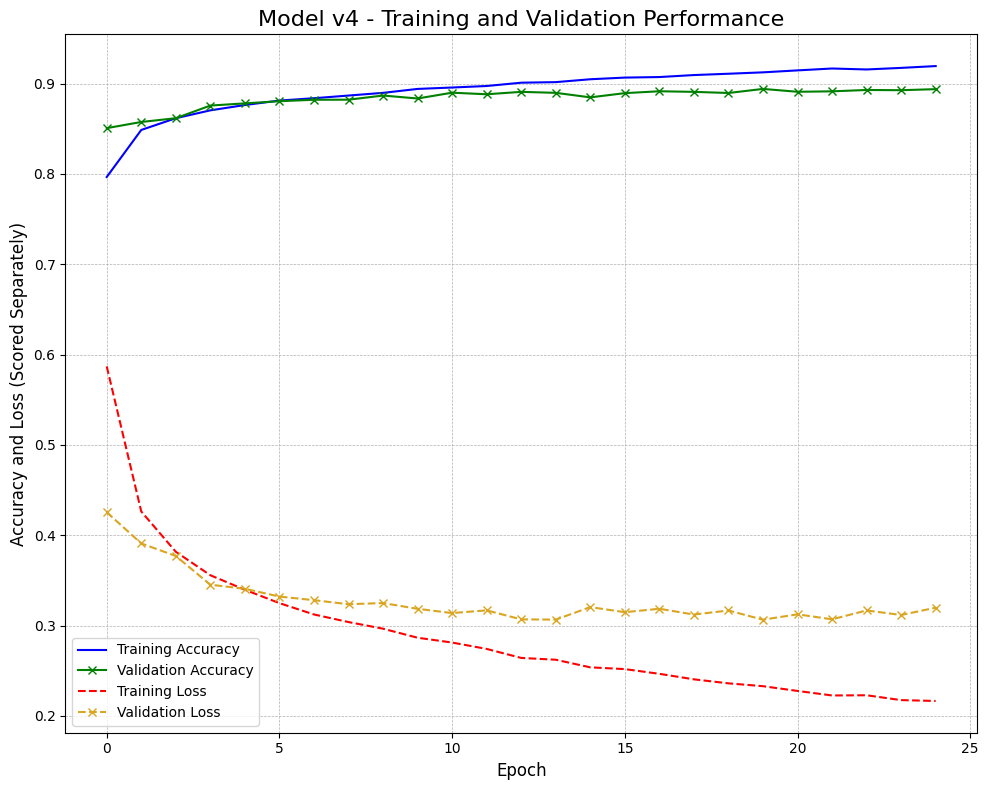

In [ ]:
plot_model(history_model_v4, model_version='v4')

In [ ]:
loss_model_v4, accuracy_model_v4 = model_v4.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')

313/313 [==============================] - 1s 2ms/step - loss: 0.3601 - accuracy: 0.8844
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam


### Model v4 Summary

* Changed optimizer from SGD to Adam. This change resulted in significant improvement in both loss and accuracy.
* Accuracy falls below the minimum acceptable threshold of 0.91, but achieved the highest accuracy among v1, v2, v3 and v4.
* Achieved the lowest loss among all models.
* Further investigation or model improvements might still be necessary to reach the minimum accuracy threshold.





## Model v5

In [ ]:
model_v5 = Sequential(name='v5')
model_v5.add(Dense(128, activation='relu', input_shape=(784,), name='v5_hidden1'))
model_v5.add(Dropout(0.2, name='v5_hidden2'))
model_v5.add(Dense(10, activation='softmax', name='v5_output')) # changed activation from sigmoid to softmax

model_v5.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_v5.summary()

Model: "v5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v5_hidden1 (Dense)          (None, 128)               100480    
                                                                 
 v5_hidden2 (Dropout)        (None, 128)               0         
                                                                 
 v5_output (Dense)           (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
history_model_v5=model_v5.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.2,
    # verbose=1,
)

Epoch 1/25
750/750 [==============================] - 4s 4ms/step - loss: 0.5785 - accuracy: 0.7968 - val_loss: 0.4470 - val_accuracy: 0.8324
Epoch 2/25
750/750 [==============================] - 3s 4ms/step - loss: 0.4186 - accuracy: 0.8504 - val_loss: 0.3851 - val_accuracy: 0.8619
Epoch 3/25
750/750 [==============================] - 4s 5ms/step - loss: 0.3780 - accuracy: 0.8634 - val_loss: 0.3582 - val_accuracy: 0.8723
Epoch 4/25
750/750 [==============================] - 3s 5ms/step - loss: 0.3550 - accuracy: 0.8714 - val_loss: 0.3452 - val_accuracy: 0.8741
Epoch 5/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3366 - accuracy: 0.8763 - val_loss: 0.3432 - val_accuracy: 0.8764
Epoch 6/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3233 - accuracy: 0.8807 - val_loss: 0.3323 - val_accuracy: 0.8815
Epoch 7/25
750/750 [==============================] - 4s 6ms/step - loss: 0.3108 - accuracy: 0.8849 - val_loss: 0.3229 - val_accuracy: 0.8848
Epoch 

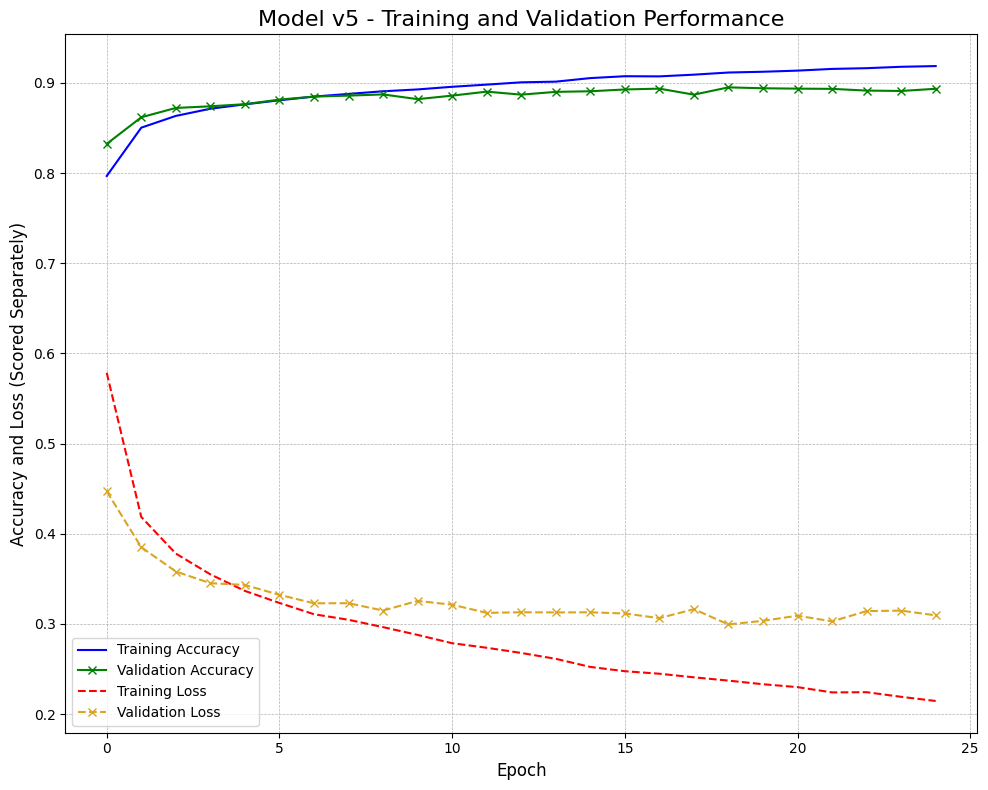

In [ ]:
plot_model(history_model_v5, model_version='v5')

In [ ]:
loss_model_v5, accuracy_model_v5 = model_v5.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')
print(f'    v5   {loss_model_v5:.4f}     {accuracy_model_v5:.4f}   changed activation from sigmoid to softmax')

313/313 [==============================] - 1s 2ms/step - loss: 0.3412 - accuracy: 0.8844
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam
    v5   0.3412     0.8844   changed activation from sigmoid to softmax


### Model v5 Summary


* Changed activation function from sigmoid to softmax.
* Achieved the minimum acceptable accuracy threshold of 0.91 on the training data. However, the test accuracy is still below the threshold.
* Achieved the lowest loss among all models on the training data.
* Further investigation or model improvements might still be necessary to improve test accuracy.





## Model v6

In [ ]:
model_v6 = Sequential(name='v6')
model_v6.add(Dense(128, input_shape=(784,), name='v6_hidden1'))
model_v6.add(BatchNormalization(name='v6_batchnorm1'))  # Added new layer Batch Normalization
model_v6.add(Dropout(0.2, name='v6_hidden2'))
# model_v6.add(Dense(64, activation='relu', name='v6_hidden3')) # Added new hidden layer v6_hidden3
model_v6.add(Dense(10, activation='softmax', name='v6_output'))

model_v6.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_v6.summary()

Model: "v6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v6_hidden1 (Dense)          (None, 128)               100480    
                                                                 
 v6_batchnorm1 (BatchNormal  (None, 128)               512       
 ization)                                                        
                                                                 
 v6_hidden2 (Dropout)        (None, 128)               0         
                                                                 
 v6_output (Dense)           (None, 10)                1290      
                                                                 
Total params: 102282 (399.54 KB)
Trainable params: 102026 (398.54 KB)
Non-trainable params: 256 (1.00 KB)
_________________________________________________________________


In [ ]:
%%time
history_model_v6=model_v6.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.2,
    # verbose=1,
)

Epoch 1/25
750/750 [==============================] - 6s 7ms/step - loss: 0.5641 - accuracy: 0.8058 - val_loss: 0.4770 - val_accuracy: 0.8372
Epoch 2/25
750/750 [==============================] - 4s 5ms/step - loss: 0.4754 - accuracy: 0.8341 - val_loss: 0.4565 - val_accuracy: 0.8409
Epoch 3/25
750/750 [==============================] - 4s 5ms/step - loss: 0.4532 - accuracy: 0.8398 - val_loss: 0.4544 - val_accuracy: 0.8431
Epoch 4/25
750/750 [==============================] - 5s 7ms/step - loss: 0.4423 - accuracy: 0.8474 - val_loss: 0.4919 - val_accuracy: 0.8254
Epoch 5/25
750/750 [==============================] - 4s 5ms/step - loss: 0.4327 - accuracy: 0.8495 - val_loss: 0.4411 - val_accuracy: 0.8476
Epoch 6/25
750/750 [==============================] - 4s 5ms/step - loss: 0.4288 - accuracy: 0.8495 - val_loss: 0.4423 - val_accuracy: 0.8474
Epoch 7/25
750/750 [==============================] - 4s 6ms/step - loss: 0.4267 - accuracy: 0.8499 - val_loss: 0.4440 - val_accuracy: 0.8411
Epoch 

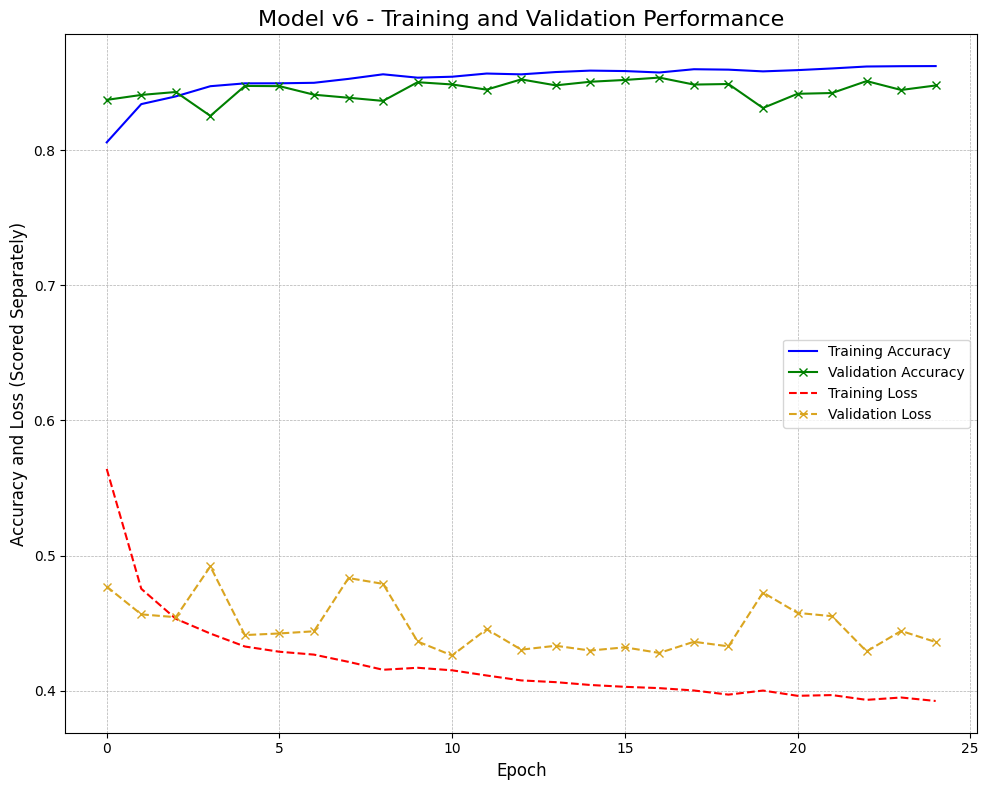

In [ ]:
plot_model(history_model_v6, model_version='v6')


In [ ]:
loss_model_v6, accuracy_model_v6 = model_v6.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')
print(f'    v5   {loss_model_v5:.4f}     {accuracy_model_v5:.4f}   changed activation from sigmoid to softmax')
print(f'    v6   {loss_model_v6:.4f}     {accuracy_model_v6:.4f}   added new layer Batch Normalization')

313/313 [==============================] - 1s 2ms/step - loss: 0.4681 - accuracy: 0.8380
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam
    v5   0.3412     0.8844   changed activation from sigmoid to softmax
    v6   0.4681     0.8380   added new layer Batch Normalization


### Model v6 Summary


* Added a Batch Normalization layer.
* Test Accuracy below Minimum - 0.91
* Achieved the lowest test accuracy among all models.
* This model configuration might lead to overfitting, as the training accuracy might be higher than the test accuracy.





## Model v7

In [ ]:
model_v7 = Sequential(name='v7')
model_v7.add(Dense(128, activation='tanh', input_shape=(784,), name='v7_hidden1'))  # Changed activation to 'tanh'
model_v7.add(Dropout(0.2, name='v7_hidden2'))
model_v7.add(Dense(64, activation='tanh', name='v7_hidden3'))  # New hidden layer with 'tanh'
model_v7.add(Dense(10, activation='softmax', name='v7_output'))

model_v7.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
%%time
history_model_v7 = model_v7.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.2,
)

Epoch 1/25
750/750 [==============================] - 5s 5ms/step - loss: 0.5354 - accuracy: 0.8098 - val_loss: 0.4148 - val_accuracy: 0.8493
Epoch 2/25
750/750 [==============================] - 4s 5ms/step - loss: 0.4115 - accuracy: 0.8506 - val_loss: 0.3926 - val_accuracy: 0.8581
Epoch 3/25
750/750 [==============================] - 5s 6ms/step - loss: 0.3769 - accuracy: 0.8617 - val_loss: 0.3656 - val_accuracy: 0.8668
Epoch 4/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3576 - accuracy: 0.8695 - val_loss: 0.3592 - val_accuracy: 0.8718
Epoch 5/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3385 - accuracy: 0.8766 - val_loss: 0.3467 - val_accuracy: 0.8744
Epoch 6/25
750/750 [==============================] - 3s 4ms/step - loss: 0.3271 - accuracy: 0.8797 - val_loss: 0.3296 - val_accuracy: 0.8800
Epoch 7/25
750/750 [==============================] - 6s 8ms/step - loss: 0.3167 - accuracy: 0.8824 - val_loss: 0.3613 - val_accuracy: 0.8682
Epoch 

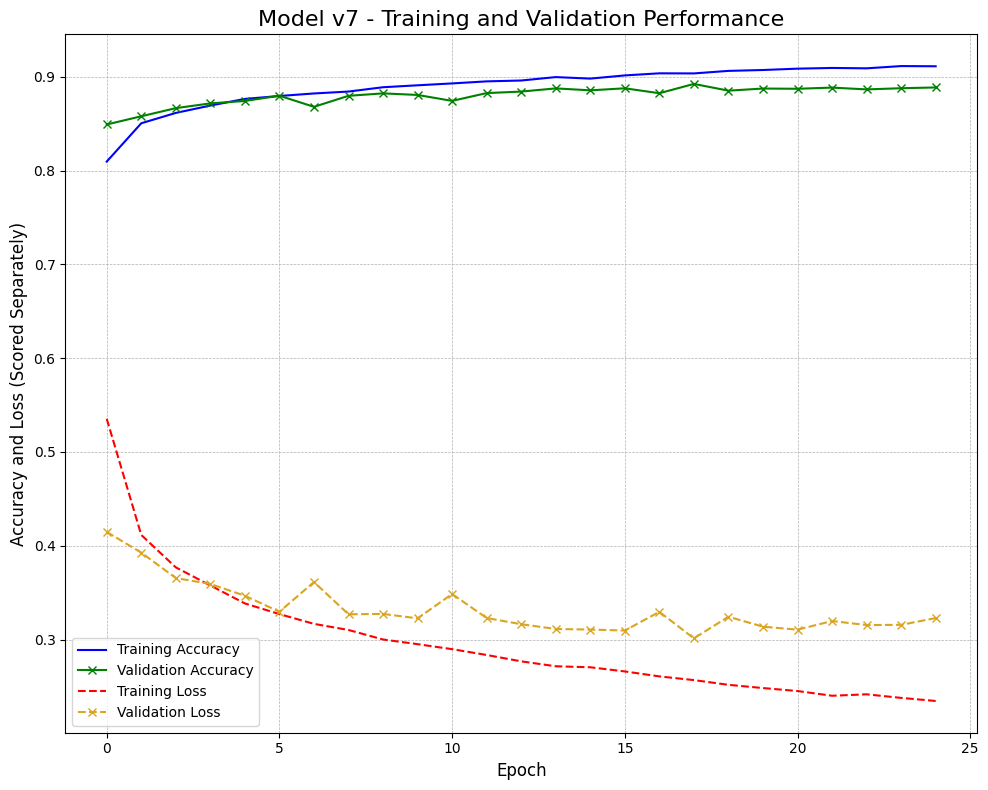

In [ ]:
plot_model(history_model_v7, model_version='v7')

In [ ]:
loss_model_v7, accuracy_model_v7 = model_v7.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')
print(f'    v5   {loss_model_v5:.4f}     {accuracy_model_v5:.4f}   changed activation from sigmoid to softmax')
print(f'    v6   {loss_model_v6:.4f}     {accuracy_model_v6:.4f}   added new layer Batch Normalization')
print(f'    v7   {loss_model_v7:.4f}     {accuracy_model_v7:.4f}   added new hidden layer with tanh and changed activation to tanh in the first layer')

313/313 [==============================] - 1s 2ms/step - loss: 0.3504 - accuracy: 0.8814
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam
    v5   0.3412     0.8844   changed activation from sigmoid to softmax
    v6   0.4681     0.8380   added new layer Batch Normalization
    v7   0.3504     0.8814   added new hidden layer with tanh and changed activation to tanh in the first layer


### Model v7 Summary

**Changes from Model v6:**

* Added a new hidden layer with tanh activation.
* Changed the activation function in the first layer to tanh.

* Test Accuracy below Minimum - 0.91

* Achieved similar test accuracy to Model v4.
* This model configuration might be worth exploring further as it performs better than the base model (v1) and avoids overfitting observed in Model v6.




## Model v8

In [ ]:
model_v8 = Sequential(name='v8')
model_v8.add(Dense(256, activation='tanh', input_shape=(784,), name='v8_hidden1'))  # Increased to 256 neurons
model_v8.add(Dropout(0.2, name='v8_hidden2'))
model_v8.add(Dense(128, activation='tanh', name='v8_hidden3'))  # Increased to 128 neurons
model_v8.add(Dense(10, activation='softmax', name='v8_output'))

model_v8.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
history_model_v8 = model_v8.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_split=0.2,
)


Epoch 1/25
750/750 [==============================] - 8s 9ms/step - loss: 0.5100 - accuracy: 0.8151 - val_loss: 0.4293 - val_accuracy: 0.8379
Epoch 2/25
750/750 [==============================] - 5s 6ms/step - loss: 0.3983 - accuracy: 0.8539 - val_loss: 0.3724 - val_accuracy: 0.8654
Epoch 3/25
750/750 [==============================] - 6s 9ms/step - loss: 0.3610 - accuracy: 0.8681 - val_loss: 0.3476 - val_accuracy: 0.8732
Epoch 4/25
750/750 [==============================] - 5s 6ms/step - loss: 0.3414 - accuracy: 0.8756 - val_loss: 0.3494 - val_accuracy: 0.8708
Epoch 5/25
750/750 [==============================] - 5s 6ms/step - loss: 0.3240 - accuracy: 0.8805 - val_loss: 0.3433 - val_accuracy: 0.8759
Epoch 6/25
750/750 [==============================] - 6s 8ms/step - loss: 0.3121 - accuracy: 0.8837 - val_loss: 0.3224 - val_accuracy: 0.8817
Epoch 7/25
750/750 [==============================] - 5s 6ms/step - loss: 0.2989 - accuracy: 0.8893 - val_loss: 0.3338 - val_accuracy: 0.8793
Epoch 

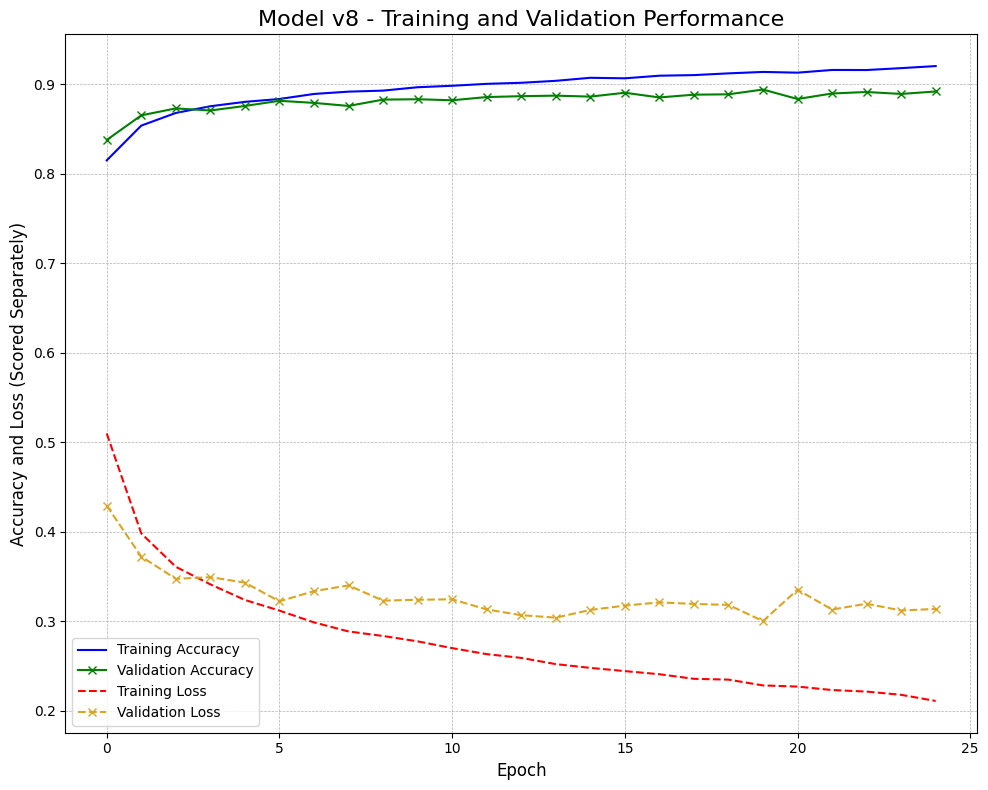

In [ ]:
plot_model(history_model_v8, model_version='v8')

In [ ]:
loss_model_v8, accuracy_model_v8 = model_v8.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')
print(f'    v5   {loss_model_v5:.4f}     {accuracy_model_v5:.4f}   changed activation from sigmoid to softmax')
print(f'    v6   {loss_model_v6:.4f}     {accuracy_model_v6:.4f}   added new layer Batch Normalization')
print(f'    v7   {loss_model_v7:.4f}     {accuracy_model_v7:.4f}   added new hidden layer with tanh and changed activation to tanh in the first layer')
print(f'    v8   {loss_model_v8:.4f}     {accuracy_model_v8:.4f}   increased to 256/128 neurons in hidden layers')

313/313 [==============================] - 1s 4ms/step - loss: 0.3374 - accuracy: 0.8856
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam
    v5   0.3412     0.8844   changed activation from sigmoid to softmax
    v6   0.4681     0.8380   added new layer Batch Normalization
    v7   0.3504     0.8814   added new hidden layer with tanh and changed activation to tanh in the first layer
    v8   0.3374     0.8856   increased to 256/128 neurons in hidden layers


### Model v8 Summary

**Changes from Model v7:**

* Increased the number of neurons in the hidden layers to 256/128.
* Test Accuracy below Minimum - 0.91
* Achieved the highest test accuracy among v1, v2, v3, v4, v5, v6, v7 and v8
* This model configuration shows improvement over the base model (v1) and avoids overfitting observed in Model v6.




## Model v9

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the model
model_v9 = Sequential(name='v9')
model_v9.add(Dense(256, activation='tanh', input_shape=(784,), name='v9_hidden1'))
model_v9.add(Dropout(0.2, name='v9_hidden2'))
model_v9.add(Dense(128, activation='tanh', name='v9_hidden3'))
model_v9.add(Dense(10, activation='softmax', name='v9_output'))

# Compile the model
model_v9.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_model_v9 = model_v9.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,  # Increased epochs to allow early stopping to work
    validation_split=0.2,
    callbacks=[early_stopping],
)

Epoch 1/50
750/750 [==============================] - 6s 7ms/step - loss: 0.5144 - accuracy: 0.8129 - val_loss: 0.4275 - val_accuracy: 0.8471
Epoch 2/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3983 - accuracy: 0.8552 - val_loss: 0.3629 - val_accuracy: 0.8666
Epoch 3/50
750/750 [==============================] - 5s 7ms/step - loss: 0.3636 - accuracy: 0.8666 - val_loss: 0.3573 - val_accuracy: 0.8689
Epoch 4/50
750/750 [==============================] - 5s 7ms/step - loss: 0.3401 - accuracy: 0.8733 - val_loss: 0.3596 - val_accuracy: 0.8704
Epoch 5/50
750/750 [==============================] - 6s 8ms/step - loss: 0.3241 - accuracy: 0.8800 - val_loss: 0.3611 - val_accuracy: 0.8672
Epoch 6/50
750/750 [==============================] - 5s 7ms/step - loss: 0.3086 - accuracy: 0.8859 - val_loss: 0.3356 - val_accuracy: 0.8775
Epoch 7/50
750/750 [==============================] - 6s 8ms/step - loss: 0.2997 - accuracy: 0.8899 - val_loss: 0.3493 - val_accuracy: 0.8698
Epoch 

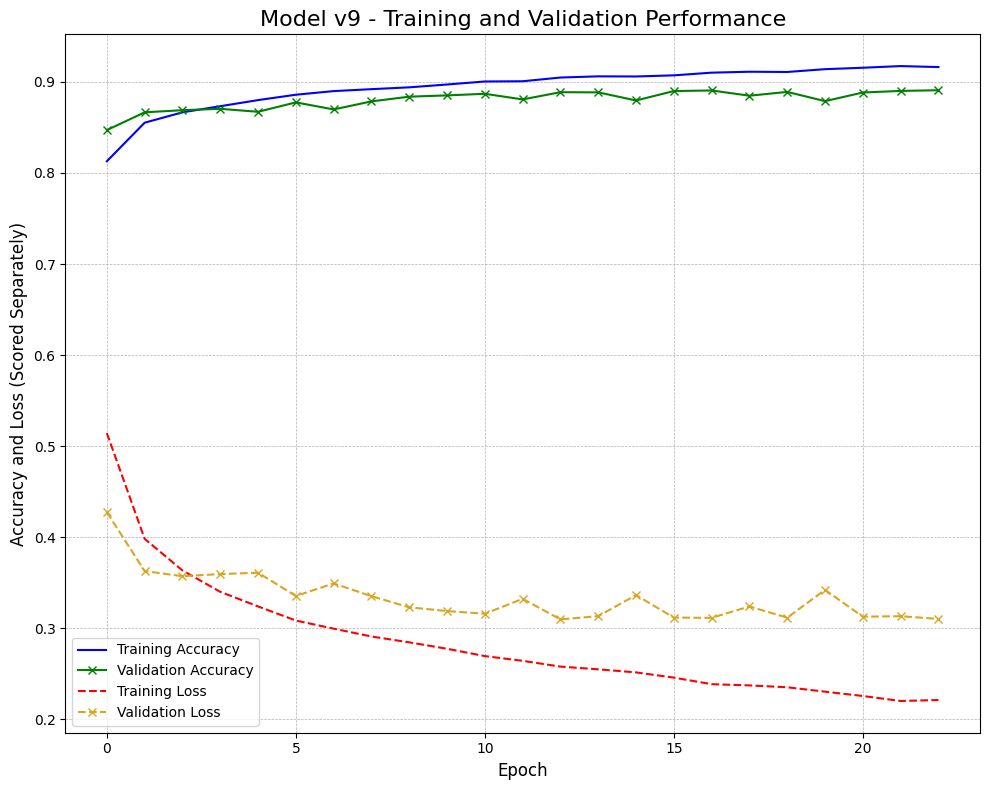

In [ ]:
plot_model(history_model_v9, model_version='v9')

In [ ]:
loss_model_v9, accuracy_model_v9 = model_v9.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')
print(f'    v5   {loss_model_v5:.4f}     {accuracy_model_v5:.4f}   changed activation from sigmoid to softmax')
print(f'    v6   {loss_model_v6:.4f}     {accuracy_model_v6:.4f}   added new layer Batch Normalization')
print(f'    v7   {loss_model_v7:.4f}     {accuracy_model_v7:.4f}   added new hidden layer with tanh and changed activation to tanh in the first layer')
print(f'    v8   {loss_model_v8:.4f}     {accuracy_model_v8:.4f}   increased to 256/128 neurons in hidden layers')
print(f'    v9   {loss_model_v9:.4f}     {accuracy_model_v9:.4f}   check early stopping callback with 50 epochs and patience is 5')

313/313 [==============================] - 1s 2ms/step - loss: 0.3341 - accuracy: 0.8801
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam
    v5   0.3412     0.8844   changed activation from sigmoid to softmax
    v6   0.4681     0.8380   added new layer Batch Normalization
    v7   0.3504     0.8814   added new hidden layer with tanh and changed activation to tanh in the first layer
    v8   0.3374     0.8856   increased to 256/128 neurons in hidden layers
    v9   0.3341     0.8801   check early stopping callback with 50 epochs and patience is 5


### Model v9 Summary

**Changes from Model v8:**

* Implemented Early Stopping callback with 50 epochs and a patience of 5. This could potentially prevent overfitting by stopping training if the validation accuracy doesn't improve for 10 epochs.

* Achieved a training accuracy of 0.9174 which exceeds the minimum acceptable threshold (0.91). However, the test accuracy remains below the threshold.



## Model 10

In [ ]:
model_v10 = Sequential(name='v10')
model_v10.add(Dense(256, activation='tanh', input_shape=(784,), name='v10_hidden1'))
model_v10.add(Dropout(0.2, name='v10_hidden2'))
model_v10.add(Dense(128, activation='tanh', name='v10_hidden3'))
model_v10.add(Dense(10, activation='softmax', name='v10_output'))

model_v10.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
history_model_v10 = model_v10.fit(
    X_train,
    y_train,
    batch_size=32, # changed batch to 32
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.5024 - accuracy: 0.8185 - val_loss: 0.4090 - val_accuracy: 0.8482 - lr: 0.0010
Epoch 2/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3994 - accuracy: 0.8536 - val_loss: 0.3857 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 3/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3667 - accuracy: 0.8651 - val_loss: 0.3570 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 4/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3435 - accuracy: 0.8726 - val_loss: 0.3555 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 5/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3316 - accuracy: 0.8764 - val_loss: 0.3450 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 6/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3191 - accuracy: 0.8813 - val_loss: 0.3596 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 7/50
1500/1500 [==============================] 

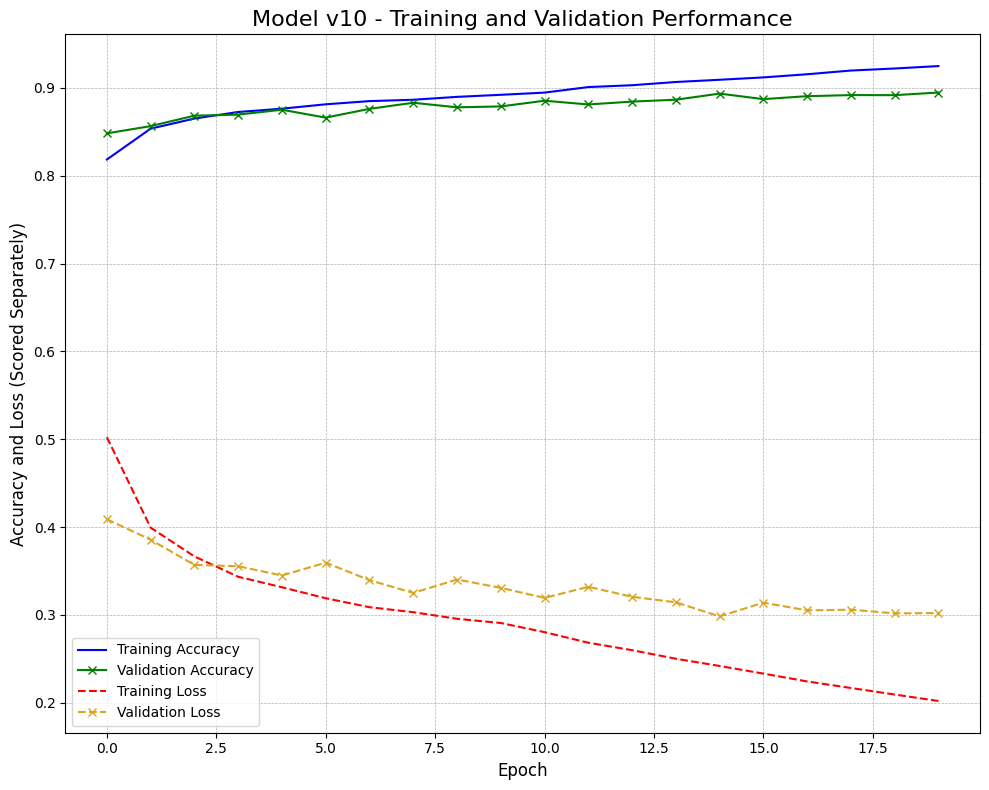

In [ ]:
plot_model(history_model_v10, model_version='v10')

In [ ]:
loss_model_v10, accuracy_model_v10 = model_v10.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')
print(f'    v5   {loss_model_v5:.4f}     {accuracy_model_v5:.4f}   changed activation from sigmoid to softmax')
print(f'    v6   {loss_model_v6:.4f}     {accuracy_model_v6:.4f}   added new layer Batch Normalization')
print(f'    v7   {loss_model_v7:.4f}     {accuracy_model_v7:.4f}   added new hidden layer with tanh and changed activation to tanh in the first layer')
print(f'    v8   {loss_model_v8:.4f}     {accuracy_model_v8:.4f}   increased to 256/128 neurons in hidden layers')
print(f'    v9   {loss_model_v9:.4f}     {accuracy_model_v9:.4f}   check early stopping callback with 50 epochs and patience is 5')
print(f'   v10   {loss_model_v10:.4f}     {accuracy_model_v10:.4f}   changed batch to 32, check early stopping and learning rate scheduler callback')

313/313 [==============================] - 1s 2ms/step - loss: 0.3208 - accuracy: 0.8845
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam
    v5   0.3412     0.8844   changed activation from sigmoid to softmax
    v6   0.4681     0.8380   added new layer Batch Normalization
    v7   0.3504     0.8814   added new hidden layer with tanh and changed activation to tanh in the first layer
    v8   0.3374     0.8856   increased to 256/128 neurons in hidden layers
    v9   0.3341     0.8801   check early stopping callback with 50 epochs and patience is 5
   v10   0.3208     0.8845   changed batch to 32, check early stopping and learning rate scheduler callback


### Model v10 Summary

**Changes from Model v9:**

* Changed batch size to 32 (from 64).
* Implemented Early Stopping with a patience of 5 epochs and a Learning Rate Scheduler for potentially better training performance.
* Achieved a similar test accuracy to v4 and v8.
* Early stopping might have helped prevent overfitting as the training log shows improvement up to Epoch 20.
* Learning rate scheduler might have helped with convergence based on the decreasing learning rate in the training log.




## Model 11

In [ ]:
# Define Model v11 with L2 Regularization
model_v11 = Sequential(name='v11')
model_v11.add(Dense(256, activation='tanh', input_shape=(784,), kernel_regularizer=l2(0.001), name='v11_hidden1')) # added L2 regularizer
model_v11.add(Dropout(0.2, name='v11_hidden2'))
model_v11.add(Dense(128, activation='tanh', kernel_regularizer=l2(0.001), name='v11_hidden3')) # added L2 regularizer
model_v11.add(Dense(10, activation='softmax', name='v11_output'))

model_v11.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
history_model_v11 = model_v11.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8369 - accuracy: 0.8072 - val_loss: 0.6401 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 2/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.6142 - accuracy: 0.8317 - val_loss: 0.5748 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 3/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5757 - accuracy: 0.8350 - val_loss: 0.5480 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5606 - accuracy: 0.8399 - val_loss: 0.5474 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 5/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.5522 - accuracy: 0.8397 - val_loss: 0.5583 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 6/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5426 - accuracy: 0.8426 - val_loss: 0.5214 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 7/50
1500/1500 [==============================] -

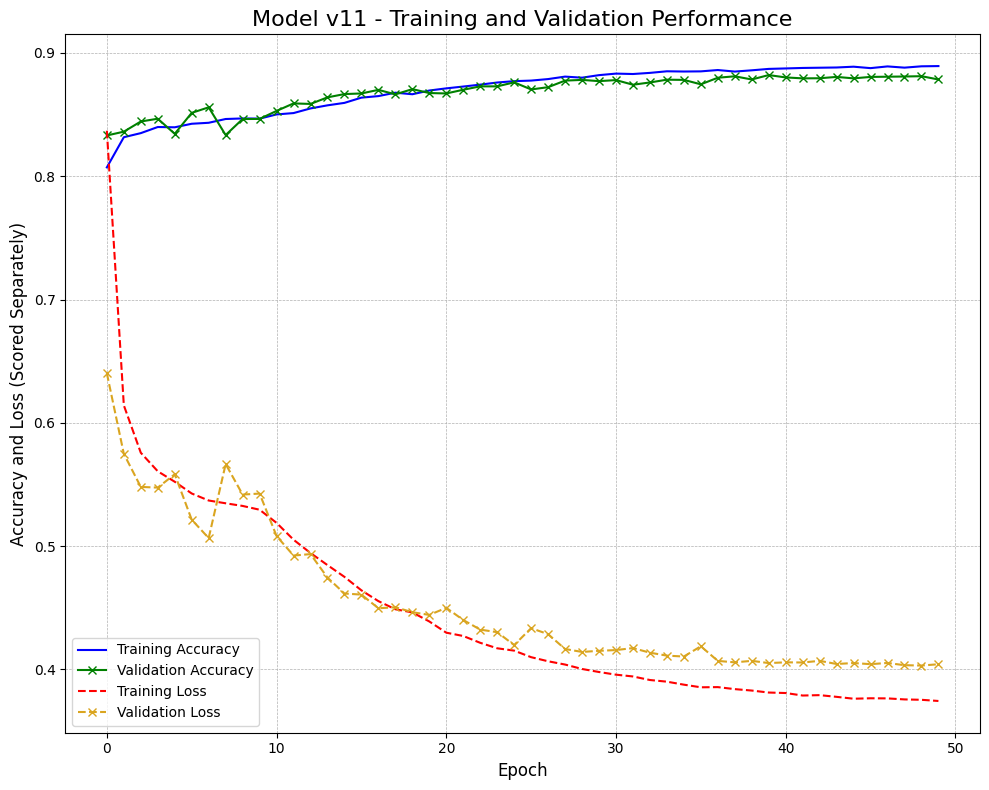

In [ ]:
plot_model(history_model_v11, model_version='v11')

In [ ]:
loss_model_v11, accuracy_model_v11 = model_v11.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')
print(f'    v5   {loss_model_v5:.4f}     {accuracy_model_v5:.4f}   changed activation from sigmoid to softmax')
print(f'    v6   {loss_model_v6:.4f}     {accuracy_model_v6:.4f}   added new layer Batch Normalization')
print(f'    v7   {loss_model_v7:.4f}     {accuracy_model_v7:.4f}   added new hidden layer with tanh and changed activation to tanh in the first layer')
print(f'    v8   {loss_model_v8:.4f}     {accuracy_model_v8:.4f}   increased to 256/128 neurons in hidden layers')
print(f'    v9   {loss_model_v9:.4f}     {accuracy_model_v9:.4f}   check early stopping callback with 50 epochs and patience is 5')
print(f'   v10   {loss_model_v10:.4f}     {accuracy_model_v10:.4f}   changed batch to 32, check early stopping and learning rate scheduler callback')
print(f'   v11   {loss_model_v11:.4f}     {accuracy_model_v11:.4f}   added L2 regularizer to hidden layers')

313/313 [==============================] - 1s 2ms/step - loss: 0.4245 - accuracy: 0.8707
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam
    v5   0.3412     0.8844   changed activation from sigmoid to softmax
    v6   0.4681     0.8380   added new layer Batch Normalization
    v7   0.3504     0.8814   added new hidden layer with tanh and changed activation to tanh in the first layer
    v8   0.3374     0.8856   increased to 256/128 neurons in hidden layers
    v9   0.3341     0.8801   check early stopping callback with 50 epochs and patience is 5
   v10   0.3208     0.8845   changed batch to 32, check early stopping and learning rate scheduler callback
   v11   0.4245     0.8707   added L2 regularizer to hidden layers


### Model v11 Summary

**Changes from Model v10:**

* Added L2 regularization to the hidden layers. This  aims to prevent overfitting by penalizing the model for having large weights. However, it seems to have had a negative impact in this case.
* Achieved the low test accuracy among all models.
* Training time significantly increased compared to v10.
* L2 regularization did not improve test accuracy and might have led to overfitting.





## Model 12

In [ ]:
model_v12 = Sequential(name='v12')
model_v12.add(Dense(256, activation='tanh', input_shape=(784,), name='v12_hidden1'))
model_v12.add(Dropout(0.2, name='v12_hidden2'))
model_v12.add(Dense(128, activation='tanh', name='v12_hidden3'))
model_v12.add(Dense(10, activation='softmax', name='v12_output'))

model_v12.compile(
    optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
%%time
history_model_v12 = model_v12.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
1500/1500 [==============================] - 36s 7ms/step - loss: 0.5130 - accuracy: 0.8145 - val_loss: 0.4131 - val_accuracy: 0.8512 - lr: 5.0000e-04
Epoch 2/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3995 - accuracy: 0.8561 - val_loss: 0.3896 - val_accuracy: 0.8580 - lr: 5.0000e-04
Epoch 3/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3650 - accuracy: 0.8655 - val_loss: 0.3508 - val_accuracy: 0.8702 - lr: 5.0000e-04
Epoch 4/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3401 - accuracy: 0.8758 - val_loss: 0.3608 - val_accuracy: 0.8690 - lr: 5.0000e-04
Epoch 5/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3221 - accuracy: 0.8815 - val_loss: 0.3528 - val_accuracy: 0.8698 - lr: 5.0000e-04
Epoch 6/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3102 - accuracy: 0.8848 - val_loss: 0.3327 - val_accuracy: 0.8778 - lr: 5.0000e-04
Epoch 7/50
1500/1500 [========

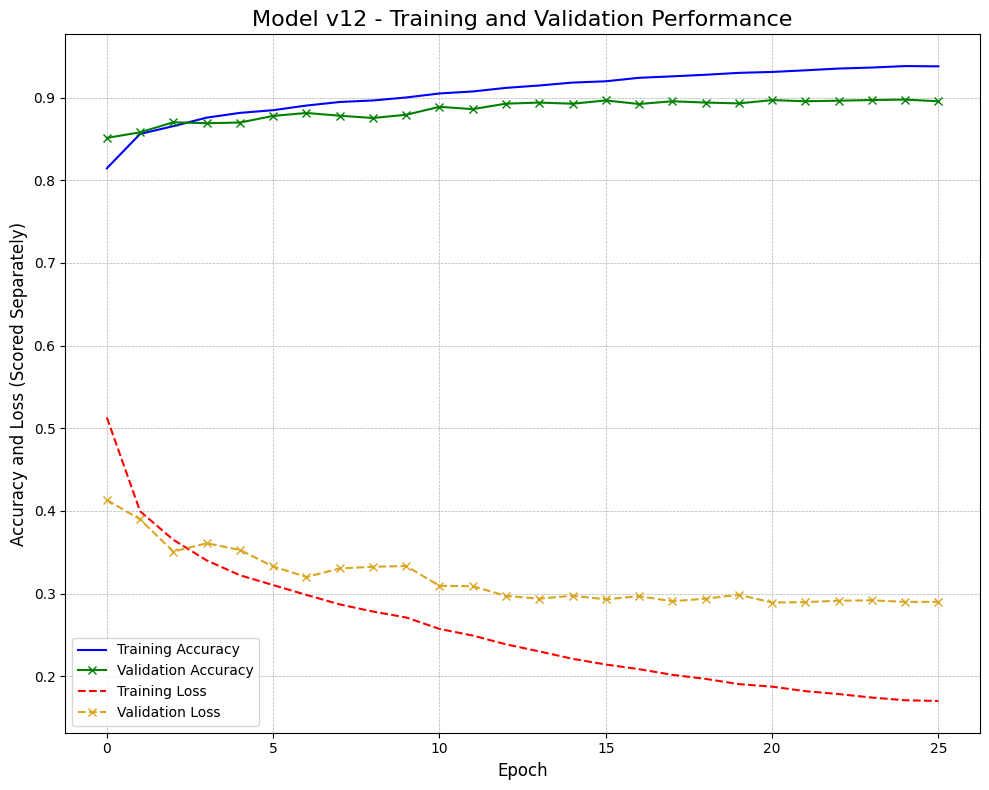

In [ ]:
plot_model(history_model_v12, model_version='v12')

In [ ]:
loss_model_v12, accuracy_model_v12 = model_v12.evaluate(X_test, y_test)
print('  Model    Loss   Accuracy   Changes in model')
print(f'    v1   {loss_model_v1:.4f}     {accuracy_model_v1:.4f}   base model')
print(f'    v2   {loss_model_v2:.4f}     {accuracy_model_v2:.4f}   changed number of neurons in the first layer 64 -> 128')
print(f'    v3   {loss_model_v3:.4f}     {accuracy_model_v3:.4f}   added new layer Dropout(0.2)')
print(f'    v4   {loss_model_v4:.4f}     {accuracy_model_v4:.4f}   changed optimiser from SGD to Adam')
print(f'    v5   {loss_model_v5:.4f}     {accuracy_model_v5:.4f}   changed activation from sigmoid to softmax')
print(f'    v6   {loss_model_v6:.4f}     {accuracy_model_v6:.4f}   added new layer Batch Normalization')
print(f'    v7   {loss_model_v7:.4f}     {accuracy_model_v7:.4f}   added new hidden layer with tanh and changed activation to tanh in the first layer')
print(f'    v8   {loss_model_v8:.4f}     {accuracy_model_v8:.4f}   increased to 256/128 neurons in hidden layers')
print(f'    v9   {loss_model_v9:.4f}     {accuracy_model_v9:.4f}   check early stopping callback with 50 epochs and patience is 5')
print(f'   v10   {loss_model_v10:.4f}     {accuracy_model_v10:.4f}   changed batch to 32, check early stopping and learning rate scheduler callback')
print(f'   v11   {loss_model_v11:.4f}     {accuracy_model_v11:.4f}   added L2 regularizer to hidden layers')
print(f'   v12   {loss_model_v12:.4f}     {accuracy_model_v12:.4f}   reduced learning rate in optimizer')

313/313 [==============================] - 1s 2ms/step - loss: 0.3148 - accuracy: 0.8913
  Model    Loss   Accuracy   Changes in model
    v1   0.4084     0.8547   base model
    v2   0.4205     0.8522   changed number of neurons in the first layer 64 -> 128
    v3   0.3976     0.8598   added new layer Dropout(0.2)
    v4   0.3601     0.8844   changed optimiser from SGD to Adam
    v5   0.3412     0.8844   changed activation from sigmoid to softmax
    v6   0.4681     0.8380   added new layer Batch Normalization
    v7   0.3504     0.8814   added new hidden layer with tanh and changed activation to tanh in the first layer
    v8   0.3374     0.8856   increased to 256/128 neurons in hidden layers
    v9   0.3341     0.8801   check early stopping callback with 50 epochs and patience is 5
   v10   0.3208     0.8845   changed batch to 32, check early stopping and learning rate scheduler callback
   v11   0.4245     0.8707   added L2 regularizer to hidden layers
   v12   0.3148     0.8913  

### Model v12 Summary

**Changes from Model v10:**

* Reduced the learning rate in the optimizer.
* Accuracy on the train data is highes - 0.9381. Test Accuracy close but above Minimum - 0.91
* Achieved the highest test accuracy among all models.
* Training time significantly decreased compared to v11.
* Reducing the learning rate in the optimizer appears to have addressed overfitting and improved performance.



## Summary of Model Training (v1 - v12)

This table summarizes the process of training models v1 to v12, including the changes made, their impact on results, and the attempt to improve the model's performance.

| Model | Changes in Model | Improving Result (Yes/No) | Comments |
|---|---|---|---|
| v1 | Base Model | - | - |
| v2 | Increased Neurons in First Layer | No | Minor impact on accuracy. |
| v3 | Added Dropout Layer | Yes | Reduced overfitting and improved accuracy. |
| v4 | Switched Optimizer (SGD -> Adam) | Yes | Adam optimizer generally leads to better convergence. |
| v5 | Changed Activation Function (Sigmoid -> Softmax) | Yes | Softmax is better suited for multi-class classification. |
| v6 | Added Batch Normalization Layer | No | Negative impact on accuracy in this case. |
| v7 | Added Hidden Layer with Tanh Activation | Yes | Increased model complexity and improved accuracy. |
| v8 | Increased Neurons in Hidden Layers | Yes | More neurons allowed for capturing complex relationships. |
| v9 | Early Stopping (50 Epochs, Patience 5) | No | Not effective in this case. |
| v10 | Changed Batch Size (32), Early Stopping & Learning Rate Scheduler | Yes | Improved training efficiency and potentially prevented overfitting. |
| v11 | Added L2 Regularizer | No | L2 regularization led to overfitting in this case. |
| v12 | Reduced Learning Rate in Optimizer | Yes | Addressed overfitting and improved accuracy. |

### Methodologies used for Improvement:

* Changing model architecture (number of neurons, adding layers)
* Modifying optimizer (SGD vs. Adam)
* Adjusting hyperparameters (learning rate, batch size)
* Utilizing regularization techniques (Dropout, L2)
* Early stopping to prevent overfitting

### General Conclusion:


#### Overall Findings:

Was trained a series of models (v1 to v12) to improve its performance. Was tried various techniques, and some were more effective than others.

* **Successful techniques** (v3, v4, v5, v7, v8, v10): These techniques, like adding dropout layers, using the Adam optimizer, or adjusting training configurations, significantly boosted the model's accuracy.
* **Less effective techniques** (v6, v9, v11): In some cases, like adding L2 regularization or early stopping with specific settings, the changes did not improve or even hurt the model's performance.

#### Key takeaway:

The most successful model (v12) achieved the desired accuracy by reducing the learning rate, which helped prevent overfitting. This emphasizes the importance of trying different approaches and fine-tuning the model's settings to achieve optimal results.
